<a href="https://colab.research.google.com/github/dreamkatana/Brazilian_currency_without_augmentation/blob/main/Brazilian_currency_without_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Brazilian currency Classification Without Image Augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dreamkatana/Brazilian_currency_without_augmentation/blob/main/Brazilian_currency_without_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/dreamkatana/Brazilian_currency_without_augmentation/blob/main/Brazilian_currency_without_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

We will train this model for bills of 20BRL and 50BRL using minimal original photos, but with thousands of variation of the same images.
<br>
To generate the variation I created a python script to read the folder and output the result.
  <a target="_blank" href="https://github.com/dreamkatana/rotate_size_python"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>

<hr>


**Before you begin**

Before running the code in this notebook, reset the runtime by going to **Runtime -> Reset all runtimes** in the menu above. If you have been working through several notebooks, this will help you avoid reaching Colab's memory limits.


# Importing packages

Let's start by importing required packages:

*   os — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data


In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Data Loading

To build our image classifier, we begin by downloading the dataset. The dataset we are using is a filtered version of <a href="https://drive.google.com/u/0/uc?id=1JTJnxW6fPPOgYbINUCqkCiH5zF4iUaKy&export=download&confirm=t" target="_blank">20BRL vs. 50BRL</a> dataset from João Eduardo.

In [5]:
_URL = 'https://drive.google.com/u/0/uc?id=1JTJnxW6fPPOgYbINUCqkCiH5zF4iUaKy&export=download&confirm=t'
zip_dir = tf.keras.utils.get_file('20_and_50_filtered.zip', origin=_URL, extract=True)

283493651/283493651 [==============================] - 8s 0us/step


The dataset we have downloaded has the following directory structure.

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>20_and_50_filtered</b>
|__ <b>train</b>
    |______ <b>20</b>: [*.jpg, *.jpg, *.jpg ...]
    |______ <b>50</b>: [*.jpg, *.jpg, *.jpg ...]
|__ <b>validation</b>
    |______ <b>20</b>: [*.jpg, *.jpg, *.jpg ...]
    |______ <b>50</b>: [*.jpg, *.jpg, *.jpg ...]
</pre>

We can list the directories with the following terminal command:

In [6]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/20_and_50_filtered
/root/.keras/datasets/20_and_50_filtered/validation
/root/.keras/datasets/20_and_50_filtered/validation/20
/root/.keras/datasets/20_and_50_filtered/validation/50
/root/.keras/datasets/20_and_50_filtered/train
/root/.keras/datasets/20_and_50_filtered/train/20
/root/.keras/datasets/20_and_50_filtered/train/50


We'll now assign variables with the proper file path for the training and validation sets.

In [7]:
base_dir = os.path.join(os.path.dirname(zip_dir), '20_and_50_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_20_dir = os.path.join(train_dir, '20')  # directory with our training 20BRL pictures
train_50_dir = os.path.join(train_dir, '50')  # directory with our training 50BRL pictures
validation_20_dir = os.path.join(validation_dir, '20')  # directory with our validation 20BRL pictures
validation_50_dir = os.path.join(validation_dir, '50')  # directory with our validation 50BRL pictures

### Understanding our data

Let's look at how many 20BRL and 50BRL images we have in our training and validation directory

In [8]:
num_20_tr = len(os.listdir(train_20_dir))
num_50_tr = len(os.listdir(train_50_dir))

num_20_val = len(os.listdir(validation_20_dir))
num_50_val = len(os.listdir(validation_50_dir))

total_train = num_20_tr + num_50_tr
total_val = num_20_val + num_50_val

In [9]:
print('total training 20 currency bill images:', num_20_tr)
print('total training 50 currency bill images:', num_50_tr)

print('total validation 20 currency bill images:', num_20_val)
print('total validation 50 currency bill images:', num_50_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training 20 currency bill images: 14079
total training 50 currency bill images: 9747
total validation 20 currency bill images: 455
total validation 50 currency bill images: 168
--
Total training images: 23826
Total validation images: 623


# Setting Model Parameters

For convenience, we'll set up variables that will be used later while pre-processing our dataset and training our network.

In [28]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels

# Data Preparation 

Images must be formatted into appropriately pre-processed floating point tensors before being fed into the network. The steps involved in preparing these images are:

1. Read images from the disk
2. Decode contents of these images and convert it into proper grid format as per their RGB content
3. Convert them into floating point tensors
4. Rescale the tensors from values between 0 and 255 to values between 0 and 1, as neural networks prefer to deal with small input values.

Fortunately, all these tasks can be done using the class **tf.keras.preprocessing.image.ImageDataGenerator**.

We can set this up in a couple of lines of code.

In [29]:
train_image_generator      = ImageDataGenerator(rescale=1./255)  # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255)  # Generator for our validation data

After defining our generators for training and validation images, **flow_from_directory** method will load images from the disk, apply rescaling, and resize them using single line of code.

In [30]:
train_data_gen = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary')

Found 23826 images belonging to 2 classes.


In [31]:
val_data_gen = validation_image_generator.flow_from_directory(batch_size=BATCH_SIZE,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                              class_mode='binary')

Found 623 images belonging to 2 classes.


### Visualizing Training images

We can visualize our training images by getting a batch of images from the training generator, and then plotting a few of them using `matplotlib`.

In [32]:
sample_training_images, _ = next(train_data_gen) 

The `next` function returns a batch from the dataset. One batch is a tuple of (*many images*, *many labels*). For right now, we're discarding the labels because we just want to look at the images.

In [33]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

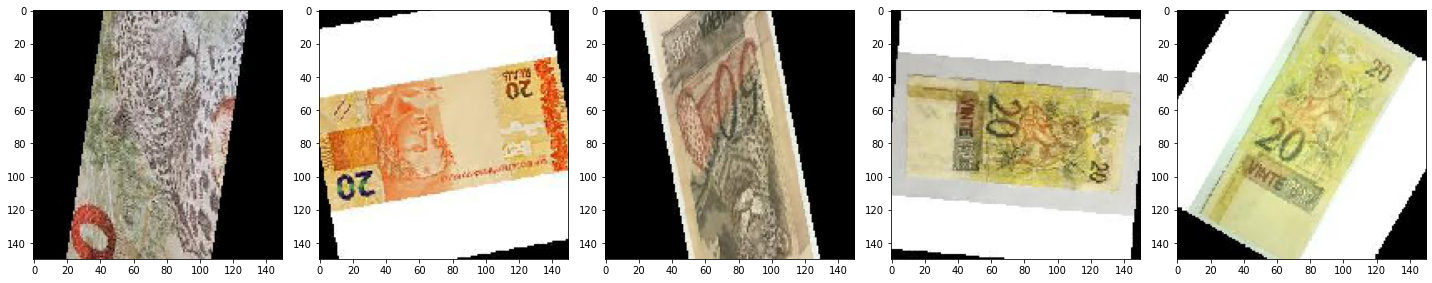

In [34]:
plotImages(sample_training_images[:5])  # Plot images 0-4

# Model Creation

## Define the model

The model is the InceptionV3 from Keras. The model will output class probabilities for two classes — 50 and 20 — using `softmax`. 

In [35]:

#model = tf.keras.models.Sequential([
#    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
#    tf.keras.layers.MaxPooling2D(2, 2),

#    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
#    tf.keras.layers.MaxPooling2D(2,2),

#    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#    tf.keras.layers.MaxPooling2D(2,2),
      
#    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
 #   tf.keras.layers.MaxPooling2D(2,2),
    
#    tf.keras.layers.Flatten(),
#    tf.keras.layers.Dense(512, activation='relu'),
 #   tf.keras.layers.Dense(2)
#])

model = tf.keras.applications.InceptionV3(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

### Compile the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [36]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Model Summary

Let's look at all the layers of our network using **summary** method.

In [37]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 149, 149, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 149, 149, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

### Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [38]:
EPOCHS = 30
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


239/239 [==============================] - 89s 323ms/step - loss: 0.0946 - accuracy: 0.9872 - val_loss: 0.1673 - val_accuracy: 0.9518
Epoch 2/30
239/239 [==============================] - 75s 312ms/step - loss: 1.3022e-05 - accuracy: 1.0000 - val_loss: 0.2697 - val_accuracy: 0.9294
Epoch 3/30
239/239 [==============================] - 76s 316ms/step - loss: 4.8516e-06 - accuracy: 1.0000 - val_loss: 0.2344 - val_accuracy: 0.9374
Epoch 4/30
239/239 [==============================] - 75s 315ms/step - loss: 3.6694e-06 - accuracy: 1.0000 - val_loss: 0.2406 - val_accuracy: 0.9374
Epoch 5/30
239/239 [==============================] - 75s 315ms/step - loss: 2.9343e-06 - accuracy: 1.0000 - val_loss: 0.2354 - val_accuracy: 0.9358
Epoch 6/30
239/239 [==============================] - 76s 316ms/step - loss: 1.6160e-06 - accuracy: 1.0000 - val_loss: 0.2488 - val_accuracy: 0.9358
Epoch 7/30
239/239 [==============================] - 75s 315ms/step - loss: 3.6364e-06 - accuracy: 1.0000 - val_loss: 0.

### Visualizing results of the training

We'll now visualize the results we get after training our network.

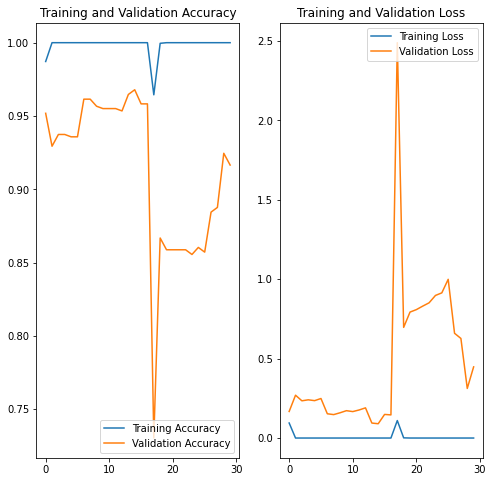

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./foo.png')
plt.show()

As we can see from the plots, training accuracy and validation accuracy are off by large margin and our model has achieved only around **70%** accuracy on the validation set (depending on the number of epochs you trained for).

This is a clear indication of overfitting. Once the training and validation curves start to diverge, our model has started to memorize the training data and is unable to perform well on the validation data.